In [ ]:
!gdown --id  1rgsp8det7GM9UiuBFyPIrboBXQwDuMdj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rgsp8det7GM9UiuBFyPIrboBXQwDuMdj
To: /content/best.onnx
100% 44.6M/44.6M [00:00<00:00, 90.8MB/s]


In [ ]:
!pip install ultralytics
!pip install onnxruntime

In [ ]:
import numpy as np
import cv2

CLASS_NAMES = ['FIRE', 'SMOKE']

# Create a list of colors for each class where each color is a tuple of 3 integer values
rng = np.random.default_rng(3)
COLORS = rng.uniform(0, 255, size=(len(CLASS_NAMES), 3))


def non_maximum_suppression(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes


def multi_class_nms(boxes, scores, class_ids, iou_threshold):

    unique_class_ids = np.unique(class_ids)

    keep_boxes = []
    for class_id in unique_class_ids:
        class_indices = np.where(class_ids == class_id)[0]
        class_boxes = boxes[class_indices, :]
        class_scores = scores[class_indices]

        class_keep_boxes = non_maximum_suppression(class_boxes, class_scores, iou_threshold)
        keep_boxes.extend(class_indices[class_keep_boxes])

    return keep_boxes


def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou


def xywh_to_xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def draw_detections(image, boxes, scores, class_ids, mask_alpha=0.3):
    det_image = image.copy()


    img_height, img_width = image.shape[:2]
    font_size = min([img_height, img_width]) * 0.001
    text_thickness = int(min([img_height, img_width]) * 0.001)

    det_image = draw_masks(det_image, boxes, class_ids, mask_alpha)

    for class_id, box, score in zip(class_ids, boxes, scores):
        color = COLORS[class_id]


        label = CLASS_NAMES[class_id]
        draw_box(det_image, box, color)
        caption = f'{label} {int(score * 100)}%'
        draw_text(det_image, caption, box, color, font_size, text_thickness)
        print(caption)

    return det_image


def draw_box(image, box, color=(0, 0, 255), thickness=2):
    x1, y1, x2, y2 = box.astype(int)
    return cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)


def draw_text(image, text, box, color=(0, 0, 255), font_size=0.001, text_thickness=1):
    x1, y1, x2, y2 = box.astype(int)
    (tw, th), _ = cv2.getTextSize(text=text, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                 fontScale=font_size, thickness=text_thickness)
    th = int(th * 1.2)

    cv2.rectangle(image, (x1, y1), (x1 + tw, y1 - th), color, -1)

    return cv2.putText(image, text, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), text_thickness, cv2.LINE_AA)


def draw_masks(image, boxes, classes, mask_alpha=0.3):
    mask_image = image.copy()

    for box, class_id in zip(boxes, classes):
        color = COLORS[class_id]

        x1, y1, x2, y2 = box.astype(int)

        cv2.rectangle(mask_image, (x1, y1), (x2, y2), color, -1)

    return cv2.addWeighted(mask_image, mask_alpha, image, 1 - mask_alpha, 0)


In [ ]:
import time
import cv2
import numpy as np
import onnxruntime

class YOLOv8:

    def __init__(self, model_path, confidence_threshold=0.7, iou_threshold=0.5):
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold

        # Initialize model
        self.initialize_model(model_path)

    def __call__(self, image):
        return self.detect_objects(image)

    def initialize_model(self, model_path):
        self.session = onnxruntime.InferenceSession(model_path, providers=onnxruntime.get_available_providers())
        # Get model info
        self.get_input_details()
        self.get_output_details()


    def detect_objects(self, image):
        input_tensor = self.prepare_input(image)

        # Perform inference on the image
        outputs = self.inference(input_tensor)

        self.boxes, self.scores, self.class_ids = self.process_output(outputs)

        return self.boxes, self.scores, self.class_ids

    def prepare_input(self, image):
        self.image_height, self.image_width = image.shape[:2]

        input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize input image
        input_image = cv2.resize(input_image, (self.input_width, self.input_height))

        # Scale input pixel values to 0 to 1
        input_image = input_image / 255.0
        input_image = input_image.transpose(2, 0, 1)
        input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)

        return input_tensor


    def inference(self, input_tensor):
        start_time = time.perf_counter()
        outputs = self.session.run(self.output_names, {self.input_names[0]: input_tensor})

        # print(f"Inference time: {(time.perf_counter() - start_time)*1000:.2f} ms")
        return outputs

    def process_output(self, output):
        predictions = np.squeeze(output[0]).T

        # Filter out object confidence scores below threshold
        scores = np.max(predictions[:, 4:], axis=1)
        predictions = predictions[scores > self.confidence_threshold, :]
        scores = scores[scores > self.confidence_threshold]

        if len(scores) == 0:
            return [], [], []

        # Get the class with the highest confidence
        class_ids = np.argmax(predictions[:, 4:], axis=1)

        # Get bounding boxes for each object
        boxes = self.extract_boxes(predictions)

        # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
        # indices = nms(boxes, scores, self.iou_threshold)
        indices = multi_class_nms(boxes, scores, class_ids, self.iou_threshold)

        return boxes[indices], scores[indices], class_ids[indices]

    def extract_boxes(self, predictions):
        # Extract boxes from predictions
        boxes = predictions[:, :4]

        # Scale boxes to original image dimensions
        boxes = self.rescale_boxes(boxes)

        # Convert boxes to xyxy format
        boxes = xywh_to_xyxy(boxes)

        return boxes

    def rescale_boxes(self, boxes):

        # Rescale boxes to original image dimensions
        input_shape = np.array([self.input_width, self.input_height, self.input_width, self.input_height])
        boxes = np.divide(boxes, input_shape, dtype=np.float32)
        boxes *= np.array([self.image_width, self.image_height, self.image_width, self.image_height])
        return boxes

    def draw_detections(self, image, draw_scores=True, mask_alpha=0.4):

        return draw_detections(image, self.boxes, self.scores, self.class_ids, mask_alpha)

    def get_input_details(self):
        model_inputs = self.session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]

        self.input_shape = model_inputs[0].shape
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]

    def get_output_details(self):
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def detect(img,model_path):
    # Initialize yolov8 object detector
    # model_path = r"model/yolo_best.onnx"
    yolov8_detector = YOLOv8(model_path, confidence_threshold=0.2, iou_threshold=0.3)

    # Detect Objects
    boxes, scores, class_ids = yolov8_detector(img)

    # Draw detections
    img = yolov8_detector.draw_detections(img)


    # cv2.namedWindow("Result",cv2.WINDOW_NORMAL)
        # Resize the image
    width = 800  # specify the width you want
    height = 500  # specify the height you want
    resized_img = cv2.resize(img, (width, height))
    cv2_imshow(resized_img)

    # cv2.imshow("Result", resized_img)
    # if cv2.waitKey(0) & 0xFF == ord('q'):
    #     cv2.destroyAllWindows()
    #     return



Saving PHOTO.jpg to PHOTO.jpg


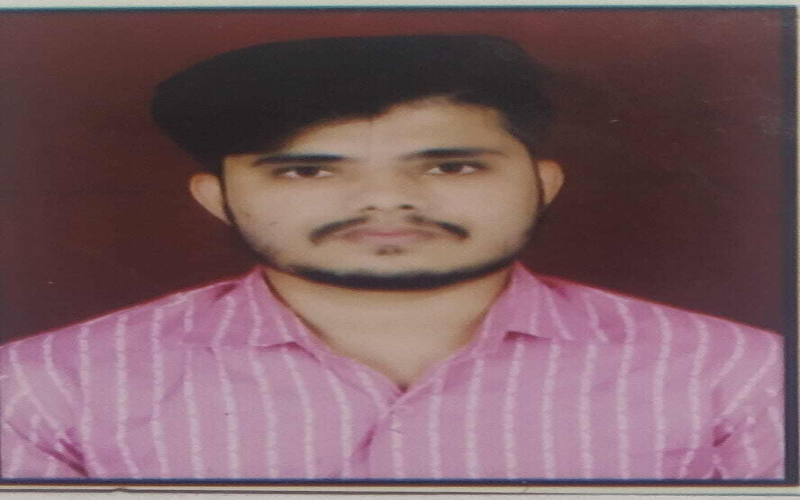




Saving droneinflight_wide-208531e09b2624e190131e2d45a86bf1ccbb2ec1.jpg to droneinflight_wide-208531e09b2624e190131e2d45a86bf1ccbb2ec1.jpg
FIRE 25%
FIRE 20%


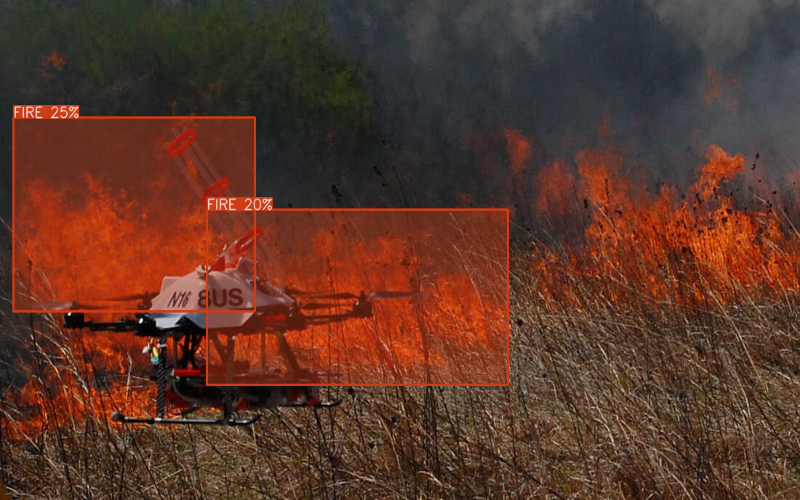

Saving droneinflight_wide-208531e09b2624e190131e2d45a86bf1ccbb2ec1.jpg to droneinflight_wide-208531e09b2624e190131e2d45a86bf1ccbb2ec1 (1).jpg
FIRE 46%
SMOKE 24%


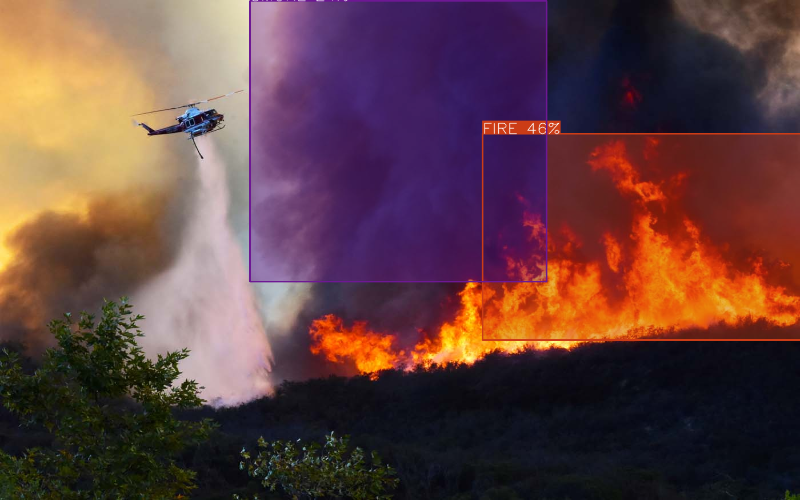

Saving droneinflight_wide-208531e09b2624e190131e2d45a86bf1ccbb2ec1.jpg to droneinflight_wide-208531e09b2624e190131e2d45a86bf1ccbb2ec1 (2).jpg
FIRE 58%


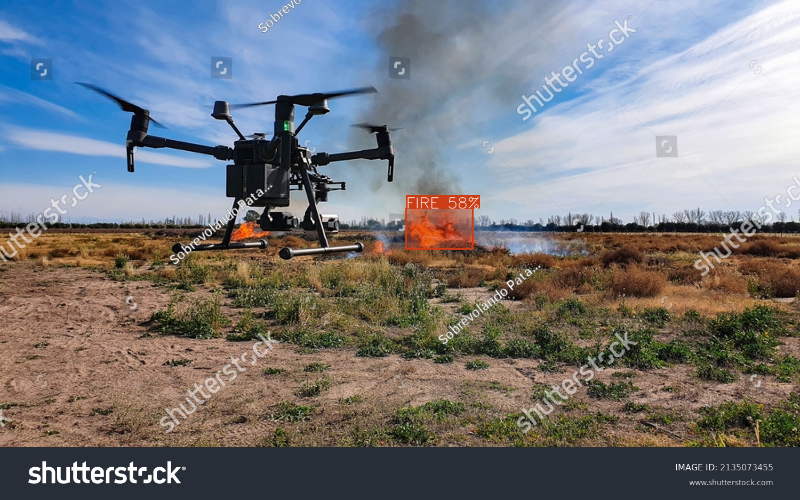

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
import cv2
import math

import os
from google.colab import files

# Function to check if the file has a valid image extension
def is_valid_image(filename):
    valid_extensions = [".jpg", ".jpeg", ".png"]
    _, file_extension = os.path.splitext(filename)
    return file_extension.lower() in valid_extensions

while 1:
  # Get the uploaded image name
  print("\n\n")
  uploaded_file = files.upload()
  image_name = list(uploaded_file.keys())[0]
  # Check if the uploaded file has a valid image extension
  if not is_valid_image(image_name):
      print("Invalid file extension. Please upload an image with a valid extension.")
      continue

  img = cv2.imread(image_name)

  detect(img, "best.onnx")

